# Infomación de entrega

**Nombre estudiante:**


## 0) Setup

In [ ]:
!pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [621]:
# Importar librerías

In [622]:
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout


## 1) Carga del dataset

El dataset Cora consiste en 2.708 papers científicos clasificados en una de 7 posibles clases. La red de citas/referencias consiste en 5.429 arcos. Cada paper tiene un vector de palabras binario de tamaño 1.433, indicando la presencia o ausencia de la palabra correspondiente.

El dataset tiene dos archivos separados:

1. El archivo `cora.cites` incluye las citas/referencias en dos columnas:
`cited_paper_id` (*target*) y `citing_paper_id` (*source*).
2. El archivo `cora.content` incluye una descripción del contenido del paper en 1.435 columnas: `paper_id`, `subject`, y 1.433 *features* binarias.


In [623]:
# Descarga de datos
!mkdir -p ./data/cora
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -O ./data/cora.tgz
!tar -xvzf ./data/cora.tgz -C ./data/cora/ --strip-components=1

--2024-10-31 06:26:04--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘./data/cora.tgz’

./data/cora.tgz     100%[===================>] 164.11K   851KB/s    in 0.2s    

2024-10-31 06:26:04 (851 KB/s) - ‘./data/cora.tgz’ saved [168052/168052]

cora/README
cora/cora.cites
cora/cora.content


In [624]:
# Cargar datos utilizando pandas

In [625]:
citations = pd.read_csv(
    Path("data", "cora", "cora.cites"),
    names=["target", "source"],
    sep="\t",
    header=None,
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [626]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [627]:
citations.sample(frac=1).head()

,target,source
1632,8875,18582
2967,38205,1129610
2225,19621,7297
2595,28287,1106547
137,35,608326


In [628]:
# Cargar el archivo `cora.content` en un DataFrame
content = pd.read_csv(
    Path("data", "cora", "cora.content"),  # Especifica la ruta del archivo
    sep="\t",  # Especifica que las columnas están separadas por tabulaciones
    header=None  # Indica que el archivo no tiene encabezado en la primera fila
)

# Renombrar las columnas para mejorar la legibilidad
content.columns = ["paper_id"] + [f"term_{i}" for i in range(1433)] + ["subject"]

# Mostrar las primeras filas de la tabla
content.head()


,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


El código carga y prepara el archivo cora.content, asignándole nombres a las columnas y mostrando la dimensión del conjunto de datos.

In [629]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(Path("data", "cora", "cora.content"), sep="\t", header=None, names=column_names)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [630]:
papers.sample(5).T

,2497,255,1882,654,759
paper_id,1132416,1119751,1110950,46452,38537
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


In [631]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [632]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

#### Preguntas

Una vez cargado el dataset debes responder las siguientes preguntas:

1. ¿Qué tipos de nodos y aristas tiene el grafo?

2. ¿Cuántas features tiene cada nodo?

3. ¿Cuántos nodos y aristas forman el grafo?


#### Respuestas


```
# Respuestas:
```



1. ¿Qué tipos de nodos y aristas tiene el grafo?

* Los nodos en el grafo representan los papers, con sus respectivos identificadores (paper_id) y 1433 features binarias.
* Las aristas representan las citas entre los papers, donde target indica el paper citado y source indica el paper que hace la cita. Esto forma un grafo dirigido, donde las aristas tienen dirección desde el paper que cita hacia el paper citado.

2. ¿Cuántas features tiene cada nodo?

* Cada nodo tiene 1433 features binarias, que indican la presencia o ausencia de palabras en el contenido del paper.

3. ¿Cuántos nodos y aristas forman el grafo?

* El grafo tiene:
  * 2,708 nodos (papers)
  * 5,429 aristas (citas).

## 2) Análisis del grafo

Un paso importante antes de aplicar *machine learning* sobre un conjunto de datos es el análisis de datos. Para esto, aprovecharemos de usar la librería NetworkX para obtener información sobre nuestro grafo.

In [633]:
# Crear grafo en NetworkX con datos cargados

In [634]:
%%time
cora_graph = nx.from_pandas_edgelist(citations.sample(n=2000))  # Nuevo grafo
pos = nx.spring_layout(cora_graph, seed=0)  # Posición de los nodos

CPU times: user 21.6 s, sys: 64 ms, total: 21.7 s
Wall time: 22 s


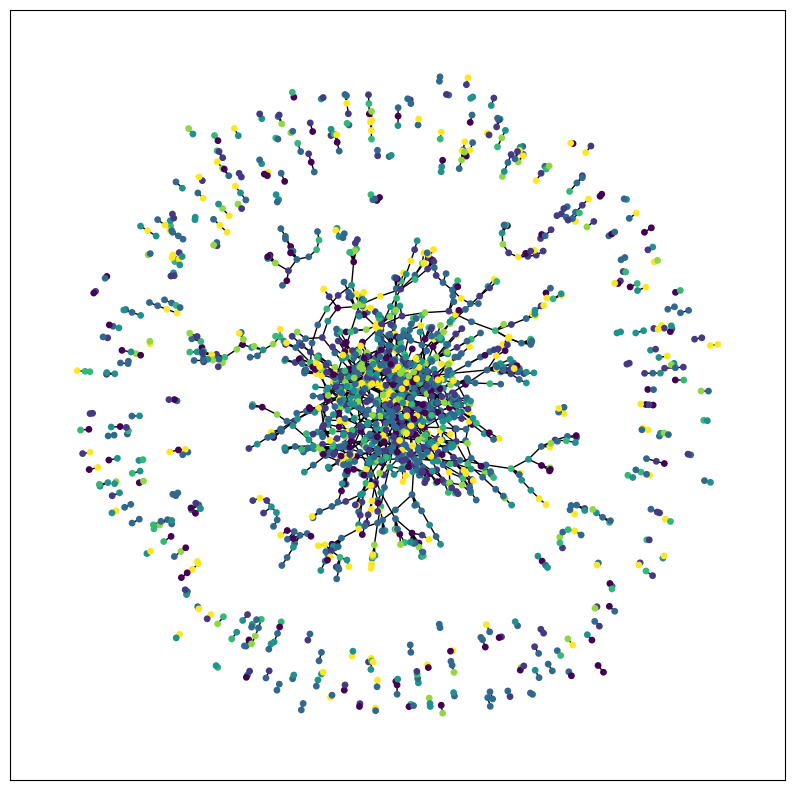

In [635]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_networkx(cora_graph, pos=pos, node_size=15, node_color=subjects, with_labels=False)  # Gráfico

In [636]:
# Grado promedio de los nodos en el grafo
average_degree = sum(dict(cora_graph.degree()).values()) / cora_graph.number_of_nodes()
print("Grado promedio:", average_degree)

Grado promedio: 2.026666666666667


In [637]:
# Diámetro del grafo
if nx.is_connected(cora_graph):
    # Si el grafo está conectado, calcula el diámetro directamente
    diameter = nx.diameter(cora_graph)
else:
    # Si el grafo no está conectado, selecciona el componente más grande
    largest_cc = max(nx.connected_components(cora_graph), key=len)
    largest_subgraph = cora_graph.subgraph(largest_cc)  # Crea el subgrafo del componente más grande
    diameter = nx.diameter(largest_subgraph)  # Calcula el diámetro del subgrafo más grande

print("Diámetro del grafo:", diameter)

Diámetro del grafo: 38


In [638]:
# Densidad de la matriz de adyacencia del grafo

density = nx.density(cora_graph)
print("Densidad del grafo:", density)


Densidad del grafo: 0.0010398494954677612


#### Preguntas

Una vez instanciado el grafo, debes responder las siguientes preguntas utilizando NetworkX:

1. ¿Cuál es el grado promedio de los nodos en el grafo?

2. ¿Cuál es el diámetro del grafo?

3. ¿Cuál es la densidad de la matriz de adyacencia del grafo?

4. Realizar un gráfico mostrando los nodos (un subconjunto) y sus arcos respectivos


```
# Respuestas:
```



1. `Grado promedio de los nodos en el grafo`: El grado promedio de los nodos en el grafo es `2.026`, lo que significa que, en promedio, cada artículo está conectado a casi dos otros artículos. Esto sugiere que los artículos en este conjunto de datos suelen citar solo unos pocos otros trabajos. En términos generales, esta conexión baja nos indica que hay mucha variedad y poca interconexión directa entre artículos.

2. `Diámetro del grafo`: El diámetro del grafo es `38`, que representa la mayor distancia entre dos artículos conectados dentro del mismo componente del grafo. Esto nos dice que, en el peor de los casos, habría que pasar por hasta `38` conexiones para ir de un artículo a otro. En una red de citaciones, un diámetro grande como este sugiere que los temas pueden estar bastante separados, ya que algunos artículos solo se conectan a otros a través de varias citas intermedias.

3. `Densidad de la matriz de adyacencia del grafo`: La densidad del grafo es `0.00103`, es decir, solo el `0.103%` de todas las posibles conexiones están presentes. Esto refuerza la idea de que el grafo es muy disperso y de que la mayoría de los artículos no tienen citas directas entre sí. Es común en redes de citaciones, donde los artículos suelen citar solo a trabajos específicos y no a todos los disponibles.

4. La imagen se encuentra graficada anteriormente pero se adjunta en esta respuesta.

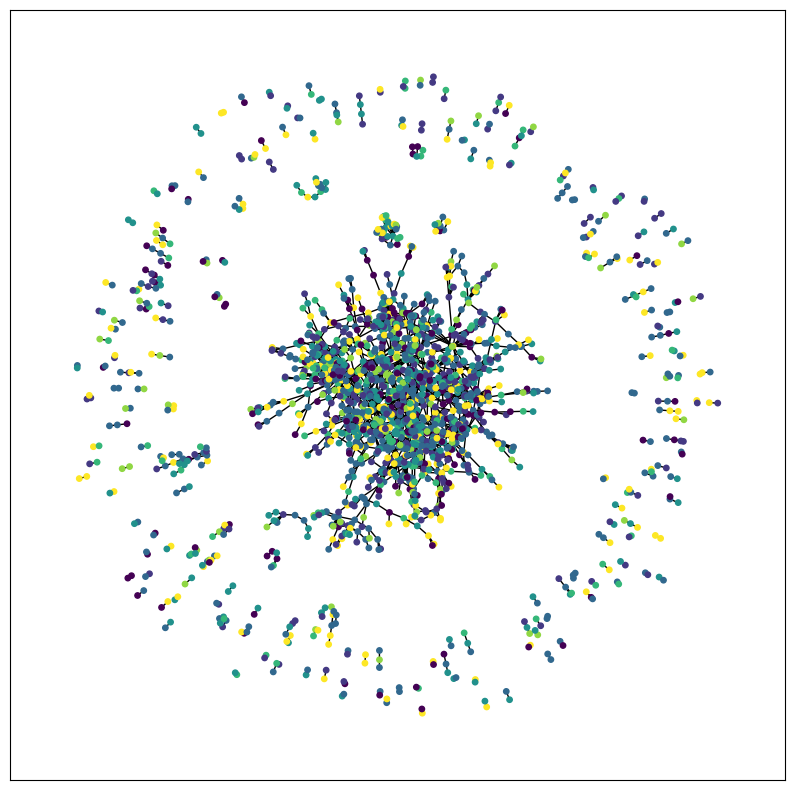

## 3) Split del dataset


Otro paso importante es realizar la partición de datos etiquetados en conjuntos de entrenamiento y test. Para esto, para cada etiqueta, se debe tomar la mitad de los papers para cada conjunto (50%).

In [639]:
# Partición de datos en train y test como numpy array

In [640]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Seleccionamos cerca del 50% del dataset para entrenamiento
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1319, 1435)
Test data shape: (1389, 1435)


In [641]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Separamos las features de entrenamiento y test como numpy array
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Separamos las etiquetas de entrenamiento y test como numpy array
y_train = train_data["subject"]
y_test = test_data["subject"]

#### Preguntas

1. ¿En qué formato se encuentran almacenados los splits?
2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no haceerlo de manera estratificada)?
3. ¿Estamos en presencia de un contexto inductivo o transductivo?
4. Mencione un ejemplo de técnica de *data augmentation* que podría aplicar en este conjunto de datos.
5. Si tuviéramos los *timestamps* de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

```
# Respuestas:
```



1. ¿En qué formato se encuentran almacenados los splits?

 * Los splits de los datos, es decir, los conjuntos de entrenamiento y prueba, se encuentran almacenados en el formato de arrays de NumPy. Esto permite un manejo eficiente y rápido de los datos durante el entrenamiento de modelos de machine learning.

2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no hacerlo de manera estratificada)?

 * Si no realizamos la partición de manera estratificada y tomamos muestras de todo el conjunto de datos de forma aleatoria, podríamos terminar con un conjunto de entrenamiento o prueba que no represente adecuadamente a todas las clases. Esto puede llevar a un modelo sesgado, ya que podría aprender más sobre algunas clases que sobre otras, afectando su rendimiento y capacidad de generalización cuando se enfrenta a datos no vistos.
3. ¿Estamos en presencia de un contexto inductivo o transductivo?

 * Estamos en un contexto transductivo. En un contexto transductivo, el modelo se entrena solo con un conjunto de datos (entrenamiento) y luego se evalúa en el mismo conjunto de datos (prueba). Es decir solo se trabaja con un mismo grafo.

4. Mencione un ejemplo de técnica de data augmentation que podría aplicar en este conjunto de datos.

 * Un ejemplo de técnica de data augmentation que podría aplicarse es la perturbación de características. Esto implica modificar ligeramente los valores de las características de los papers, como agregar ruido a las características numéricas (por ejemplo, el número de citas o la duración del paper). Esto puede ayudar a mejorar la robustez del modelo al proporcionarle más variabilidad en los datos de entrenamiento.

5. Si tuviéramos los timestamps de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

 * Sí, podríamos utilizar los timestamps de publicación para realizar la partición de los datos. Una forma de hacerlo sería dividir el conjunto de datos basado en un periodo de tiempo. Por ejemplo, podríamos seleccionar los papers publicados antes de una cierta fecha para el conjunto de entrenamiento y los publicados después para el conjunto de prueba. Esto permitiría simular un escenario en el que el modelo aprende de la información histórica y luego se evalúa en datos más recientes, lo que podría ser útil para evaluar su capacidad de generalización y adaptación a nuevas tendencias.

## 4) Creacion de la red

### GCN

En este paso, deberás crear una GCN. Para esto, deberás definir la clase `GraphConvLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = \text{ADD}(\text{MEAN}(\{W^{(l)} \times h_u^{(l-1)}, u\in N(v)\}), W^{(l)} \times h_v^{(l-1)})$

1. Cálculo del mensaje
2. Agregación de los mensajes de vecinos (usar promedio)
3. Actualizar *embedding* de cada nodo usando la suma de los mensajes agregados y la representación actual del nodo.

Por otra parte, para definir la GCN deberás definir la clase `GCNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GCNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphConvLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [723]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [724]:
hidden_units=[8, 16]
dropout_rate=0.3
aggregation_type="mean"
combination_type="concat"
normalize=True
learning_rate=0.01
num_epochs = 300
batch_size = 256

In [725]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [726]:
def run_experiment(model, x_train, y_train):
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Creación de callback paara early stopping asegurando al menos 100 epocas
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=100, restore_best_weights=True
    )
    # Entrenamiento del modelo
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [727]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [728]:
# Funciona con GCN y SAGE
def create_ffn1(units, name=None):
    fnn_layers = [
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(units, activation=tf.nn.relu)
    ]
    return keras.Sequential(fnn_layers, name=name)

In [729]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features and edges
graph_info = (node_features, edges)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [730]:
# Clase GraphConvLayer

In [731]:
class GraphConvLayer(layers.Layer):
    def __init__(self, hidden_units: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_units = hidden_units  # Almacena el número de unidades ocultas
        self.ffn1_prepare = create_ffn1(hidden_units)
        self.update_fn = create_ffn1(hidden_units)
# class GraphConvLayer(layers.Layer):
#     def __init__(self, hidden_units: int, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.ffn1_prepare = create_ffn1(hidden_units)
#         self.update_fn = create_ffn1(hidden_units)

    def prepare(self, node_representations):
        # node_representations.shape = [num_edges, embedding_dim]
        # Cacular los mensajes (MSG) de los vecinos
        messages = self.ffn1_prepare(node_representations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_representations):
        # node_indices.shape = [num_edges]
        # neighbour_messages.shape = [num_edges, representation_dim]
        # node_representations.shape = [num_nodes, representation_dim]
        # Aggregar (AGG) los mensajes de los vecinos calculando el promedio
        num_nodes = node_representations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_representations, aggregated_messages):
        # node_representations.shape = [num_nodes, representation_dim]
        # aggregated_messages.shape = [num_nodes, representation_dim]
        # Actualizamos la representación de cada nodo con la nueva (CONCAT)
        h = tf.concat([node_representations, aggregated_messages], axis=1)

        # Aplicamos la función de procesamiento
        node_embeddings = self.update_fn(h)
        node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, node_representations, edges):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of two elements: node_representations and edges
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        # Recuperamos los nodos de inicio (node_indices) y de llegada (neighbour_indices) desde los arcos
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations.shape = [num_edges, representation_dim]
        neighbour_repesentations = tf.gather(node_representations, neighbour_indices)

        # GCN:
        # 1. Preparamos los mensajes de los vecinos
        neighbour_messages = self.prepare(neighbour_repesentations)
        # 2. Agregamos los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_repesentations, node_representations)
        # 3. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        return self.update(node_representations, aggregated_messages)

In [732]:
# Clase GCNNodeClassifier

In [733]:
class GCNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Preprocesamiento
        self.preprocess = create_ffn1(hidden_units[0], name="preprocess")
        # Dos capas convolucionales
        self.conv1 = GraphConvLayer(hidden_units[0], name="graph_conv1")
        self.conv2 = GraphConvLayer(hidden_units[1], name="graph_conv2")
        # Capa densa final
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x = self.conv1(x, self.edges)
        x = self.conv2(x, self.edges)  # Añade la segunda capa convolucional
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [734]:
# Creación de modelo e impresión de parámetros

In [735]:
# Instanciación del modelo
gnn_model1 = GCNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
#    hidden_units=[8, 16],  # Ajuste de hidden_units según los requisitos
    hidden_units=hidden_units,
    name="gnn_model1"
)

# Crear una entrada dummy y mostrar resumen
dummy_input = tf.constant([0])
_ = gnn_model1(dummy_input)
gnn_model1.summary()

Model: "gnn_model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 8)                   │          17,204 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │             304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (1, 7)                      │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,139 (70.86 KB)

 Trainable params: 15,177 (59.29 KB)

 Non-trainable params: 2,962 (11.57 KB)

In [736]:
#tf.keras.utils.plot_model(gnn_model1, show_shapes=True, show_layer_names=True, expand_nested=True)

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?



```
Respuestas:
```
1. ¿Cuántas capas tiene, en total, el modelo?

* El modelo tiene 4 capas en total:
    * preprocess (Sequential)
    * graph_conv1 (GraphConvLayer)
    * graph_conv2 (GraphConvLayer)
    * logits (Dense)
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

 * El modelo tiene un total de 15,177 parámetros entrenables.


### Sage

En este paso, deberás crear otra GCN. Para esto, deberás definir la clase `GraphSageLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = W^{(l)}\times \text{CONCAT}(h_v^{(l-1)}, \text{MEAN}(\{h_u^{(l-1)}, u\in N(v)\}))$

1. Agregación de los mensajes de vecinos (usar promedio)
2. Actualizar *embedding* de cada nodo usando la concatenación de los mensajes agregados y la representación actual del nodo.
3. Cálculo del mensaje

Por otra parte, para definir la GCN deberás definir la clase `GSNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GSNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphSageLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [737]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [738]:
hidden_units=[8, 16]
dropout_rate=0.3
aggregation_type="mean"
combination_type="concat"
normalize=True
learning_rate=0.01
num_epochs = 300
batch_size = 256

In [739]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [740]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [741]:
# Funciona con SAGE
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [742]:
# Clase GraphSageLayer

In [743]:
class GraphSageLayer(layers.Layer):
    def __init__(
        self,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        aggregation_type=aggregation_type,
        combination_type=combination_type,
        normalize=normalize,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations, weights=None):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if weights is not None:
            neighbour_messages = neighbour_messages * tf.expand_dims(weights, -1)
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_representations = tf.gather(node_repesentations, neighbour_indices)

        """
        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)
        """
        # SAGE:
        # 1. Agregar los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_representations, node_repesentations, weights=edge_weights)
        # 2. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        updated_messages = self.update(node_repesentations, aggregated_messages)
        # 3. Preparar los mensajes resultantes
        return self.prepare(updated_messages, weights=None)

In [744]:
# Clase GSNNodeClassifier

In [745]:
class GSNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="mean",
        combination_type="concat",
        dropout_rate=dropout_rate,
        normalize=normalize,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphSageLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphSageLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [746]:
# Creación de modelo e impresión de parámetros

In [747]:
gnn_model2 = GSNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[8, 16],
    name="gnn_model2",
)

print("GNN output shape:", gnn_model2(input_node_indices=[1, 10, 100]))

gnn_model2.summary()

GNN output shape: tf.Tensor(
[[ 0.04071346 -0.05692779  0.01286825  0.0107053  -0.00076436  0.06928492
  -0.06652693]
 [ 0.02604175 -0.04359684  0.00036755  0.00498654  0.00162505  0.05013887
  -0.06347272]
 [-0.0098272  -0.00587162 -0.07562658 -0.01019277 -0.00162926 -0.01393604
  -0.00675724]], shape=(3, 7), dtype=float32)


Model: "gnn_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 16)                  │          17,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphSageLayer)         │ ?                           │             944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphSageLayer)         │ ?                           │             944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ (2708, 16)                  │             376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (3, 7)                      │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,763 (77.20 KB)

 Trainable params: 16,577 (64.75 KB)

 Non-trainable params: 3,186 (12.45 KB)

In [748]:
# tf.keras.utils.plot_model(gnn_model2, show_shapes=True, show_layer_names=True, expand_nested=True)

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?



```
Respuestas:
```
1. ¿Cuántas capas tiene, en total, el modelo?

 * El modelo tiene 5 capas en total:
     * preprocess (Sequential)
     * graph_conv1 (GraphSageLayer)
     * graph_conv2 (GraphSageLayer)
     * postprocess (Sequential)
     * logits (Dense)
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

 * El modelo tiene un total de 16,577 parámetros entrenables.


## 5) Entrenamiento de la red

Utiliza las instancias creadas para cada uno de los tipos de red y entrénalas utilizando los *splits* creados anteriormente.

Puedes utilizar la función de activación, optimizador, capas ocultas y learning rate que prefieras, pero debes entrenar por al menos 100 épocas y asegurarte de que la red efectivamente esté aprendiendo (la función de pérdida vaya bajando al menos al inicio del entrenamiento).

Se debe graficar tanto el progreso de la pérdida como el *accuracy* durante el proceso de entrenamiento y mostrar el *accuracy* logrado sobre los datos del *split* de *test*.

In [749]:
# Funciones auxiliares

Mantenemos todas las funciones auxiliares sin modificaciones

In [750]:
# Entrenamiento de red GCN

In [751]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model1, x_train, y_train)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['gamma', 'beta', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - acc: 0.1298 - loss: 1.9627 - val_acc: 0.2879 - val_loss: 1.8631
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - acc: 0.3153 - loss: 1.8384 - val_acc: 0.2879 - val_loss: 1.8374
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.3164 - loss: 1.8144 - val_acc: 0.2879 - val_loss: 1.8285
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - acc: 0.3044 - loss: 1.8123 - val_acc: 0.2879 - val_loss: 1.8232
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.3022 - loss: 1.8084 - val_acc: 0.2929 - val_loss: 1.8148
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - acc: 0.3244 - loss: 1.7912 - val_acc: 0.3333 - val_loss: 1.7817
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - acc: 0.3907 - loss: 1.7352 - val_acc: 0.4141 - val_loss: 1.7231
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - acc: 0.4083 - loss: 1.6850 - val_acc: 0.4141 - val_loss: 1.6778
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.4357 - loss: 1.6379 - va

In [752]:
# Gráficos red GCN

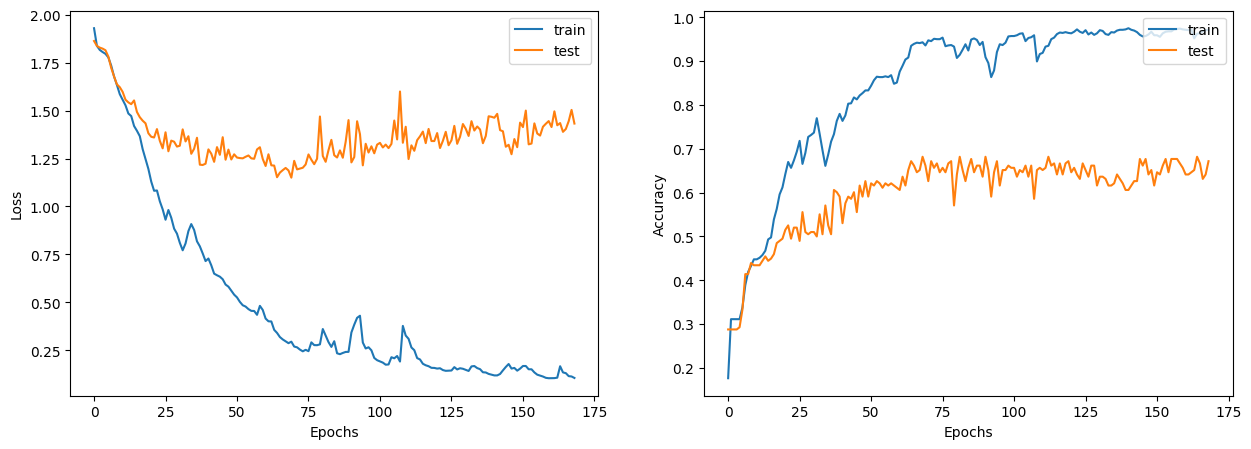

In [753]:
display_learning_curves(history)

In [754]:
# Accuracy en test de GCN

In [755]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model1.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 64.22%


In [756]:
# Entrenamiento de red GSN

In [757]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model2, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - acc: 0.2276 - loss: 1.9224 - val_acc: 0.2879 - val_loss: 1.8382
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - acc: 0.3256 - loss: 1.7813 - val_acc: 0.3586 - val_loss: 1.7195
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - acc: 0.4003 - loss: 1.6164 - val_acc: 0.4545 - val_loss: 1.5100
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - acc: 0.4370 - loss: 1.4485 - val_acc: 0.4242 - val_loss: 1.5455
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - acc: 0.5010 - loss: 1.2828 - val_acc: 0.5000 - val_loss: 1.3006
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - acc: 0.5577 - loss: 1.1028 - val_acc: 0.5051 - val_loss: 1.3595
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - acc: 0.6031 - loss: 0.9462 - val_acc: 0.5758 - val_loss: 1.1933
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - acc: 0.6993 - loss: 0.7549 - val_acc: 0.6414 - val_loss: 1.2531
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.8041 

In [758]:
# Gráficos red GSN

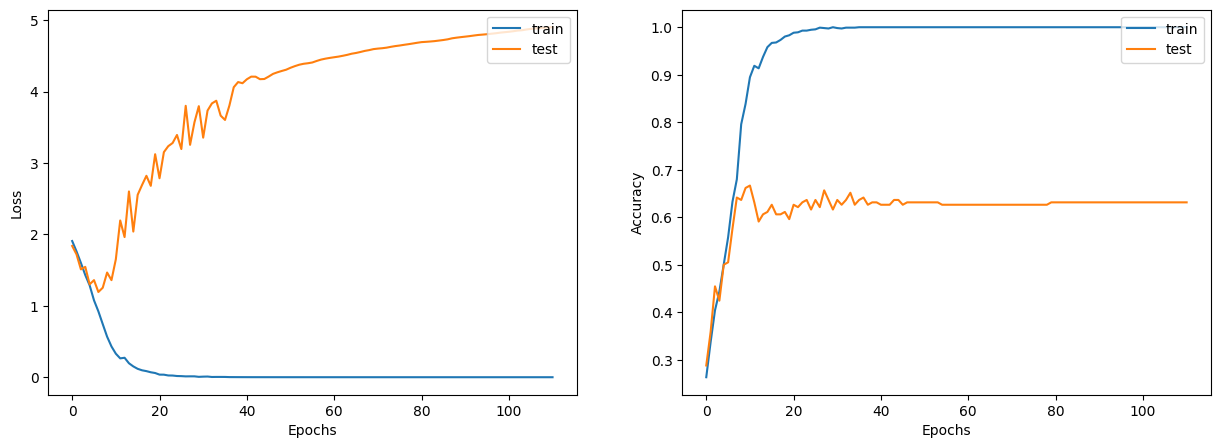

In [759]:
display_learning_curves(history)

In [760]:
# Accuracy en test de GSN

In [761]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 62.78%


### Preguntas

1. ¿Qué combinación de red obtiene mejor accuracy?
2. Comparando los dos tipos de red, ¿Es significativa la diferencia entre los accuracy?



```
Respuestas:
```
1. ¿Qué combinación de red obtiene mejor accuracy?
 * GCN obtiene un mejor accuracy
    * GCN obtiene un `64.22%`
    * GSN obtiene un `62.78%`
2. Comparando los dos tipos de red, ¿Es significativa la diferencia entre los accuracy?
 * Comparando los dos tipos de red, no, la diferencia en accuracy no es significativa entre GCN y GSN. Representa una diferencia de `1.44 puntos porcentuales`, indicando que el modelo GCN no es considerablemente más efectivo en este caso para la tarea de clasificación.
 * La decisión de invertir esfuerzo en mejorar el accuracy depende del contexto y de los requisitos de la actividad. Para algunas aplicaciones, un modelo con 65% de accuracy podría ser suficiente si el margen de error es aceptable y el costo o el tiempo de mejora no se justifica.

     * Por ejemplo:

       * Aplicaciones experimentales o educativas: Si el objetivo es aprender sobre arquitecturas de redes neuronales y experimentación, podría no ser crucial obtener el mejor accuracy.
       * Aplicaciones de producción: En aplicaciones donde la precisión es crítica (como en sistemas de diagnóstico médico o detección de fraudes), sí vale la pena optimizar para el máximo accuracy.

## 6) [Opcional] Desafío

Crea una red de tipo GNN utilizando cualquier arquitectura de las vistas, es decir, puede elegir libremente la configuración de las FNN, tasa de *dropout*, funciones de agregación y actualización, etc.

También puede utilizar alguna técnica de *data augmentation* de las mencionadas en clases.

Está prohibido utilizar cualquier librería externa que implemente alguna capa de su GNN, solo crea tu propia implementación (tal como se realizó anteriormente).

**El desafío consiste en superar por al menos un punto porcentual el rendimiento obtenido por las redes anteriores**

In [762]:
# Libre

* Se escoje utilizar la red SAGE para mejorar su rendiemiento
  * (Intento 1) de  61.8%   --> 70.03%
  * (Intento 2) de  61.65%  --> 68.73%
  * (Intento 3) de  64.94%  --> 67.17%
  * (Intento 4) de  62.78%  --> 67.89%  (Actual)


* modificando los siguiente parametros:

  * hidden_units=       [8,16]  -->   [128,64]
  * learning_rate =     0.01    -->   0.001
  * dropout_rate=       0.3     -->   0.5
  * aggregation_type=   "mean"  -->   "sum"
  * normalize=          True    -->   False

In [763]:
hidden_units=[128,64]     #[8,16]
dropout_rate=0.5          #0.3
aggregation_type="sum"    #"mean"
combination_type="concat"
normalize=False           #True
learning_rate = 0.001     #0.01
num_epochs = 300
batch_size = 256

In [764]:
# Funciona con GCN y SAGE
def create_ffn1(units, name=None):
    fnn_layers = [
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(units, activation=tf.nn.gelu)
    ]
    return keras.Sequential(fnn_layers, name=name)

In [765]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [766]:
# Funciona con SAGE
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [767]:
class GraphSageLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=dropout_rate,
        aggregation_type=aggregation_type,
        combination_type=combination_type,
        normalize=normalize,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations, weights=None):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if weights is not None:
            neighbour_messages = neighbour_messages * tf.expand_dims(weights, -1)
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_representations = tf.gather(node_repesentations, neighbour_indices)

        """
        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)
        """
        # SAGE:
        # 1. Agregar los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_representations, node_repesentations, weights=edge_weights)
        # 2. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        updated_messages = self.update(node_repesentations, aggregated_messages)
        # 3. Preparar los mensajes resultantes
        return self.prepare(updated_messages, weights=None)

In [768]:
class GSNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type=aggregation_type,
        combination_type=combination_type,
        dropout_rate=dropout_rate,
        normalize=normalize,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphSageLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphSageLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [769]:
gnn_model2 = GSNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    name="gnn_model2",
)

print("GNN output shape:", gnn_model2(input_node_indices=[1, 10, 100]))

gnn_model2.summary()

GNN output shape: tf.Tensor(
[[-4.4039479e-03  1.3606083e-02 -2.0221137e-03 -2.1095965e-02
  -9.5767342e-04 -1.1248456e-02 -2.0423438e-03]
 [ 1.6377924e-02 -6.0801124e-03  1.7135476e-03 -9.3946196e-03
   1.0813064e-02 -1.2399385e-02  1.1896350e-02]
 [ 6.7178877e-03 -2.0687284e-02  2.6868172e-03  4.2810277e-03
   2.4096487e-02  1.6675649e-02 -9.1267750e-05]], shape=(3, 7), dtype=float32)


Model: "gnn_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 64)                  │         198,052 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphSageLayer)         │ ?                           │          43,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphSageLayer)         │ ?                           │          43,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ (2708, 64)                  │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (3, 7)                      │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,123 (1.15 MB)

 Trainable params: 296,825 (1.13 MB)

 Non-trainable params: 5,298 (20.70 KB)

In [770]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model2, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step - acc: 0.2600 - loss: 1.9324 - val_acc: 0.2879 - val_loss: 1.8813
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - acc: 0.3159 - loss: 1.8455 - val_acc: 0.2879 - val_loss: 1.7855
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - acc: 0.3129 - loss: 1.7324 - val_acc: 0.2879 - val_loss: 1.7362
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - acc: 0.3214 - loss: 1.6026 - val_acc: 0.3687 - val_loss: 1.5532
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - acc: 0.5091 - loss: 1.3334 - val_acc: 0.5253 - val_loss: 1.2476
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - acc: 0.6785 - loss: 0.8848 - val_acc: 0.6111 - val_loss: 1.1561
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - acc: 0.7623 - loss: 0.6053 - val_acc: 0.6768 - val_loss: 1.2755
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - acc: 0.8737 - loss: 0.3989 - val_acc: 0.6768 - val_loss: 1.2679
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - acc: 0.900

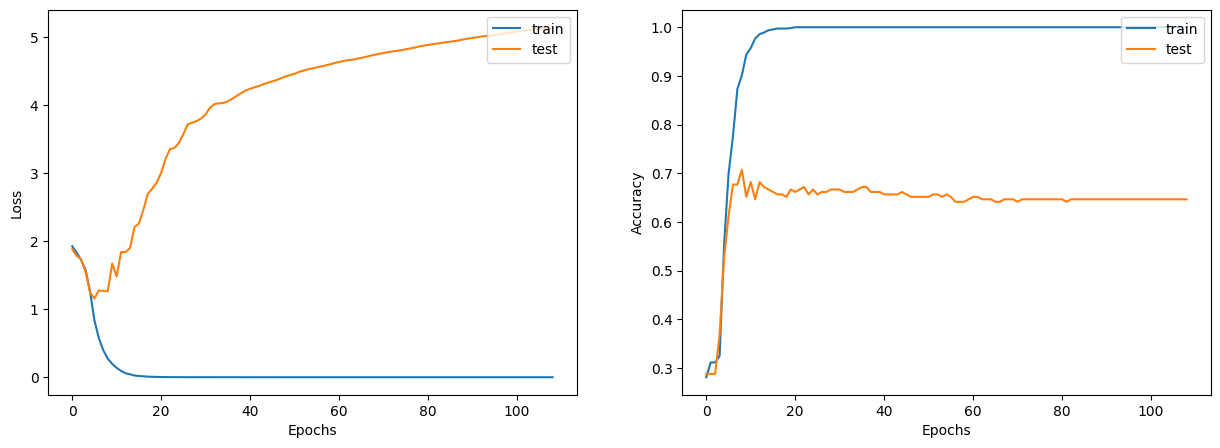

In [771]:
display_learning_curves(history)

In [772]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 67.89%
